# MR Spectroscopy with LCModel
## Analyzing MR Spectra from Rat Hippocampus
######
**Author**: Monika Doerig

**Date**: 12 Aug 2025


### Citation and Resources:


#### Tools included in this workflow
__LCModel__:
- Provencher S. W. (1993). Estimation of metabolite concentrations from localized in vivo proton NMR spectra. Magnetic resonance in medicine, 30(6), 672–679. [https://doi.org/10.1002/mrm.1910300604](https://doi.org/10.1002/mrm.1910300604)
- [LCModel documentation](http://s-provencher.com/lcmodel.shtml)
- [LCModel manual](http://s-provencher.com/pub/LCModel/manual/manual.pdf)

__Python__:

- Python Software Foundation. (2023). Python (Version 3.11.6) [Software]. Available at [https://www.python.org/](https://www.python.org/)

__Ghostscript__:
- Artifex Software, Inc. (2021). Ghostscript (Version 9.55.0) [Software]. Available at [https://www.ghostscript.com/](https://www.ghostscript.com/)
- [Documentation](https://ghostscript.readthedocs.io/en/latest/index.html)

#### Dataset
- Dunja Simicic, & Cristina Cudalbu. (2020). MR Spectra from rat hippocampus with LCModel quantification and the corresponding basis set [Data set]. In Magn Reson Med (Version Part1, Bd. 86, Nummer 5, S. 2384–2401). Zenodo. [https://doi.org/10.5281/zenodo.3904443](https://doi.org/10.5281/zenodo.3904443)

- Simicic, D., Rackayova, V., Xin, L., Tkáč, I., Borbath, T., Starcuk, Z., Jr, Starcukova, J., Lanz, B., & Cudalbu, C. (2021). In vivo macromolecule signals in rat brain 1 H-MR spectra at 9.4T: Parametrization, spline baseline estimation, and T2 relaxation times. Magnetic resonance in medicine, 86(5), 2384–2401. [https://doi.org/10.1002/mrm.28910](https://doi.org/10.1002/mrm.28910)

## Load software tools and import python libraries

In [1]:
import module
await module.load('lcmodel/6.3')
await module.list()


# Debug: Check if lcmodel is available after module load
import subprocess
import os
print(f"DEBUG: PATH after module.load = {os.environ.get('PATH', 'not set')}")
result = subprocess.run('which lcmodel', shell=True, capture_output=True, text=True)
if result.returncode == 0:
    print(f'✅ lcmodel found at: {result.stdout.strip()}')
else:
    print('❌ lcmodel NOT found in PATH after module.load()')
    raise RuntimeError("lcmodel not available - module.load() may not work in this environment")


DEBUG: PATH after module.load = /cvmfs/neurodesk.ardc.edu.au/containers/lcmodel_6.3_20220222:/opt/conda/bin:/opt/conda/condabin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/home/jovyan/.local/bin
✅ lcmodel found at: /cvmfs/neurodesk.ardc.edu.au/containers/lcmodel_6.3_20220222/lcmodel


In [2]:
%%capture 
!pip install nibabel numpy

In [3]:
# Import the necessary libraries
import matplotlib.pyplot as plt 
import os 
import subprocess
from pathlib import Path
import nibabel as nib
import numpy as np
from IPython.display import IFrame, Image, display
import re
import glob

The command below installs `Ghostscript`, which provides the `ps2pdf` utility for converting LCModel’s `.ps` output into a `PDF`, as well as tools to convert the `.ps` file into `PNG` images for easier inline viewing in notebooks and web pages.

In [4]:
!mamba install -c conda-forge ghostscript -y

[+] 0.0s
[+] 0.0s
[+] 0.1s
conda-forge/linux-64 ━━━━━━━━━━━━━╸━━━━━━━━━   0.0 B /  ??.?MB @  ??.?MB/s  0.0s
conda-forge/noarch   ━━━━━━━━━━━━━━━━━━━━━━━  14.1kB /  24.3MB @ 201.5kB/s  0.0s[+] 0.2s
conda-forge/linux-64 ━━━━━━━━━━━━━━━━━━━━━━━   1.0MB /  50.3MB @   5.5MB/s  0.1s
conda-forge/noarch   ━╸━━━━━━━━━━━━━━━━━━━━━   2.3MB /  24.3MB @  12.9MB/s  0.1s[+] 0.3s
conda-forge/linux-64 ━━━━━━━━━━━━━━━━━━━━━━━   1.7MB /  50.3MB @   7.1MB/s  0.2s
conda-forge/noarch   ━━╸━━━━━━━━━━━━━━━━━━━━   3.9MB /  24.3MB @  13.9MB/s  0.2s[+] 0.4s
conda-forge/linux-64 ╸━━━━━━━━━━━━━━━━━━━━━━   3.1MB /  50.3MB @   8.8MB/s  0.3s
conda-forge/noarch   ━━━╸━━━━━━━━━━━━━━━━━━━   4.6MB /  24.3MB @  13.3MB/s  0.3s[+] 0.5s
conda-forge/linux-64 ━╸━━━━━━━━━━━━━━━━━━━━━   4.6MB /  50.3MB @   9.3MB/s  0.4s
conda-forge/noarch   ━━━━╸━━━━━━━━━━━━━━━━━━   5.8MB /  24.3MB @  12.5MB/s  0.4s[+] 0.6s
conda-forge/linux-64 ━╸━━━━━━━━━━━━━━━━━━━━━   5.3MB /  50.3MB @   9.6MB/s  0.5s
conda-forge/noarch   ━━━━━╸━━━━━━━━━━━━━━━

In [5]:
#verify
!which gs
!which ps2pdf

/opt/conda/bin/gs
/opt/conda/bin/ps2pdf


## Introduction
This example demonstrates the processing of MR spectra acquired from the rat hippocampus using `LCModel`, a standard tool for automatic quantification of magnetic resonance spectroscopy (MRS) data.

The example Varian-format MRS dataset is processed with LCModel to quantify metabolite concentrations. Both the example data and the corresponding basis set are provided within the Neurodesk LCModel container.

Accurate quantification of MRS data requires precise preprocessing and configuration. This example illustrates the complete workflow, from raw data conversion through LCModel setup and execution to output visualization. The pipeline consists of the following steps:

__Pipeline__:
- The example dataset and basis set paths are programmatically identified within the LCModel container.

- File existence checks ensure that required data and basis files are available.

- The Varian FID file is converted to the raw format compatible with LCModel.

- Visualization of raw time-domain data is performed to assess signal quality.

- Acquisition parameters are extracted to generate the LCModel control file.

- The control file is created with appropriate settings referencing the data and basis files.

- LCModel analysis is executed via command line.

- Resulting postscript (.ps) files are converted to PDF and PNG formats for easy review and sharing.

🧾 __Glossary of Common Terms and Abbreviations__

This tutorial involves several domain-specific terms and file formats commonly used in MR spectroscopy and LCModel workflows. Below is a brief overview of key abbreviations and concepts to help you get started.

📚 For full technical details, refer to the [LCModel manual](http://s-provencher.com/pub/LCModel/manual/manual.pdf).

### Software & File Formats

| Term          | Meaning                                                                                                                                      |
| ------------- | ------------------------------------------------------------------------------------------------------- |
| **LCModel**   | A widely used software package for automatic quantification of in vivo proton MR spectra.                |
| **LCMgui**    | The graphical user interface for LCModel (optional; not used in this notebook-based workflow).           |
| **FID**       | *Free Induction Decay* — the raw time-domain MRS data typically acquired from Varian, Bruker, Siemens, or GE scanners.                       |
| **.RAW**      | LCModel-compatible input file containing unprocessed FID data in a specific ASCII format. Should not be windowed or smoothed.                |
| **.CONTROL**  | Text file that defines the analysis settings and parameters for LCModel (e.g., file paths, echo time, frequency).                            |
| **.BASIS**    | A file containing simulated model spectra for known metabolites at specific TE/TR/field strength. Used by LCModel to fit your data.          |
| **.PS**       | Optional PostScript output of LCModel’s One-Page summary, including spectra and fitted results.                                              |
| **extraInfo** | A helper file generated by `bin2raw` with basic scan metadata (e.g., `hzpppm`, `echot`).                                                     |
| **cpStart**   | Another helper file from `bin2raw`, containing default parameters that could populate a `.CONTROL` file 
                                    


### Key Control Parameters
| Parameter | Description                                                   |
| --------- | ------------------------------------------------------------- |
| `TITLE`   | Descriptive title of the scan (will appear on output).        |
| `FILRAW`  | Path to the `.RAW` file with time-domain data.                |
| `FILBAS`  | Path to the `.BASIS` file used to fit the spectrum.           |
| `FILPS`   | Path to the output `.PS` file with the report.                |
| `HZPPPM`  | Spectrometer frequency in MHz (e.g., 123.25).                 |
| `DELTAT`  | Dwell time (s), i.e., 1 / sampling frequency.                 |
| `NUNFIL`  | Number of complex points in the FID.                          |
| `ECHOT`   | Echo time (TE) in milliseconds.                               |
| `DOECC`   | Whether eddy current correction is applied (1 = yes, 0 = no). |
| `WCONC`   | Water concentration (used for absolute quantification).       |


### Data conversion tools
| Tool      | Description                                                                                                                                      |
| --------- | ------------------------------------------------------------------------------------------------------------------------------------------------ |
| `bin2raw` | LCModel utility to convert Varian-format data (FID + procpar) into a `.RAW` file. Outputs `cpStart`, `extraInfo`, and optionally an `error` log. |
| `bin2asc` | Dependency used internally by `bin2raw` for reading Varian binary formats. |

## Get example data from the container
This section locates and verifies access to the example [dataset](https://doi.org/10.5281/zenodo.3904443) bundled inside the LCModel container. It:

- Retrieves the path to the lcmodel executable to infer the container base directory.
- Constructs full paths to the example Varian fid file and BASIS set directory located within the container.
- Uses `glob` to select the `.BASIS` file (expects exactly one).
- Verifies that the `fid` file and `.BASIS` file exist and prints their status and raises an error if any are missing.

In [6]:
# ===  Get path to lcmodel executable
lcmodel_path = subprocess.check_output("which lcmodel", shell=True, text=True).strip()

# === Extract container base and image path
container_base = os.path.dirname(lcmodel_path)  # e.g., .../lcmodel_6.3_20220222
container_id = os.path.basename(container_base)  # e.g., lcmodel_6.3_20220222
simg_path = os.path.join(container_base, f"{container_id}.simg")

# ===  Construct dataset paths inside 
fid_path = os.path.join(
    simg_path,
    "opt/datasets/Spectra_hippocampus(rat)_TE02/s_20131015_03_BDL106_scan0/isise_01.fid/fid"
)
basis_path = os.path.join(
    simg_path,
    "opt/datasets/Spectra_hippocampus(rat)_TE02/Control_files_Basis_set"
)
# Get single BASIS file (will raise error if not exactly one)
basis_files = glob.glob(os.path.join(basis_path, "*.BASIS"))
basis_file = basis_files[0]


# === Check existence of the paths
fid_exists = Path(fid_path).exists()
basis_dir_exists = Path(basis_path).exists()
basis_file_exists = Path(basis_file).exists()

# === Report status
print(f"FID path:          {fid_path}")
print(f"BASIS file:        {basis_file}")
print(f"FID exists?        {'✅' if fid_exists else '❌'}")
print(f"BASIS dir exists?  {'✅' if basis_dir_exists else '❌'}")
print(f"BASIS file exists?  {'✅' if basis_file_exists else '❌'}")

# Raise error or fallback if paths missing
if not fid_exists or not basis_file_exists:
    raise FileNotFoundError("One or more required dataset paths could not be found.")

FID path:          /cvmfs/neurodesk.ardc.edu.au/containers/lcmodel_6.3_20220222/lcmodel_6.3_20220222.simg/opt/datasets/Spectra_hippocampus(rat)_TE02/s_20131015_03_BDL106_scan0/isise_01.fid/fid
BASIS file:        /cvmfs/neurodesk.ardc.edu.au/containers/lcmodel_6.3_20220222/lcmodel_6.3_20220222.simg/opt/datasets/Spectra_hippocampus(rat)_TE02/Control_files_Basis_set/9T_TE02_smallTMS_simulated-apoL0,2Hz-apoG1,8Hz_MM-ourMM_newGrad750_allRemoved.BASIS
FID exists?        ✅
BASIS dir exists?  ✅
BASIS file exists?  ✅


## Set up LCModel configuration files
This script sets up the LCModel environment by copying the hidden `.lcmodel` directory (containing all required binaries and configuration files) into your home folder. If the `.lcmodel` directory already exists, the script normally prompts whether to overwrite it — however, in a notebook environment, this prompt is not interactive. To avoid errors, the script can be conditionally run only if `.lcmodel` does not already exist.

In [7]:
if not os.path.exists(os.path.expanduser("~/.lcmodel")):
    !setup_lcmodel.sh
else:
    print("~/.lcmodel already exists — skipping setup.")

~/.lcmodel already exists — skipping setup.


## Convert Varian FID file to LCModel-compatible .RAW format
This step uses the `bin2raw` utility provided by LCModel to convert a Varian-format FID dataset and its associated procpar file into a `.RAW` file suitable for spectral fitting in LCModel.
In addition to the `.RAW` file, two auxiliary files are generated: `cpStart` and `extraInfo`. These are typically used by LCMgui to autofill settings, but in this notebook-based workflow, we'll manually extract relevant parameters from `extraInfo` and `.RAW` to generate a custom control (`.CONTROL`) file for LCModel.

**Details & Requirements for bin2raw:**

- The FID file must be named `fid`, with the corresponding `procpar` file in the same directory.

- `bin2raw` assumes a voxel volume of 1.0, so water-scaling will only be accurate if the suppressed and unsuppressed water scans were acquired with identical voxel sizes.

- `bin2raw` depends on a helper binary `bin2asc`, both of which must be located in `~/.lcmodel/varian/`.

Check if the required binaries are present:

In [8]:
! ls $HOME/.lcmodel/varian

bin2asc  bin2raw  preprocessors


Run `bin2raw` to convert the Varian fid file into an LCModel `.RAW` file. 


📁 __Output__:

This command creates the following files inside `./lcmodel_outputs/raw/`:

- `.RAW`: The converted LCModel-compatible spectral data.

- `cpStart`: Text file containing scan parameters and file paths.

- `extraInfo`: Text file providing only a subset of the scan metadata.

- `error`: A plain text log file capturing any issues or warnings during conversion. It's a good idea to check this file automatically after conversion to confirm success.


In [9]:
%%bash -s "$fid_path"

# Exit immediately if a command fails
set -e

# Input: path to directory containing 'fid' and 'procpar'
DATA_FILE="$1"

# Output directory for LCModel-compatible files
LCM_DIR="./lcmodel_outputs/"
MET_H2O="raw" #Subdirectory for the water scan or metabolite

# Create output directory if it doesn't exist
mkdir -p "${LCM_DIR}${MET_H2O}"

# Run the bin2raw conversion
$HOME/.lcmodel/varian/bin2raw $DATA_FILE $LCM_DIR $MET_H2O

### Visualizing the RAW FID data from the RAW file

The following code loads and visualizes the raw time-domain data from the `.RAW` file. This file contains the input data for a single rat from the Simicic and Cudalbu (2020) dataset. According to the study's methods, the data were acquired using a single-voxel SPECIAL sequence in the rat hippocampus, with sequence timing parameters TE = 2.8 ms and TR = 4 s. The full experiment involved collecting 160 individual acquisitions (transients) to ensure a high signal-to-noise ratio.

In MRS, a transient refers to one individual acquisition of the free induction decay (FID) signal following an excitation pulse. Multiple transients are collected and typically averaged to improve data quality.

Our plot displays a subset of this data. As will be confirmed in the next step, when we extract the acquisition parameters, the file contains the first 10 of these transients, each composed of 4096 complex data points. Each large spike in the plot marks the beginning of one of these 10 transients, corresponding to the strong initial FID signal immediately following the excitation pulse.

In [10]:
# Load data from RAW for plotting
def load_raw_data(filename):
    """
    Parses an LCModel .RAW file to extract real and imaginary parts of the FID signal.

    The .RAW file has the following structure:
    - Two NAMELIST header blocks: $SEQPAR and $NMID
    - Each ends with a line containing only '$END'
    - Time-domain FID data follows immediately after the second $END
    - The FID is stored as alternating real and imaginary float values

    Parameters
    ----------
    filename : str
        Path to the .RAW file.

    Returns
    -------
    real : np.ndarray
        Real components of the FID.
    imag : np.ndarray
        Imaginary components of the FID.
    """
    with open(filename, 'r') as f:
        lines = f.readlines()

    # Skip past the two header blocks ($SEQPAR and $NMID)
    end_count = 0
    data_start = 0
    for i, line in enumerate(lines):
        if line.strip() == '$END':
            end_count += 1
            if end_count == 2:
                # Data begins immediately after the second $END
                data_start = i + 1
                break

    data_vals = []
    # Read all lines after the second $END
    # Each line should contain exactly two float values: real and imaginary parts
    for line in lines[data_start:]:
        parts = line.strip().split()
        if len(parts) == 2:
            # Convert both parts to floats and add to the data list
            data_vals.extend([float(x) for x in parts])

    # Separate interleaved real and imaginary values
    real = np.array(data_vals[0::2])  # Even indices → real part
    imag = np.array(data_vals[1::2])  # Odd indices → imaginary part
    return real, imag


real, imag = load_raw_data("./lcmodel_outputs/raw/RAW")

**Raw Free Induction Decay (FID) Signal**:

This plot shows the unprocessed time-domain MR spectroscopy signal extracted from the `.RAW file`. The real (blue) and imaginary (red dashed) components represent the complex-valued FID acquired after excitation, before any frequency or phase correction.
Visual inspection of the FID can help identify noise, artifacts, or unexpected decay behavior prior to Fourier transformation and spectral fitting.


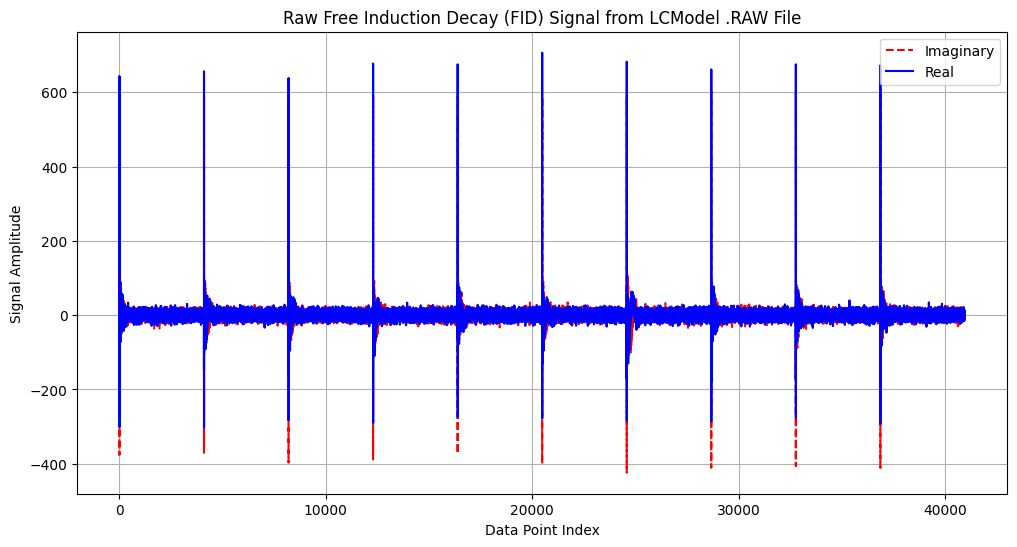

In [11]:
# Create the x-axis based on the number of FID points
data_points = np.arange(len(real))

#  Plot the data
plt.figure(figsize=(12, 6))

plt.plot(data_points, imag, label='Imaginary', color='red', linestyle='--')
plt.plot(data_points, real, label='Real', color='blue')

plt.title("Raw Free Induction Decay (FID) Signal from LCModel .RAW File")
plt.xlabel("Data Point Index")
plt.ylabel("Signal Amplitude")
plt.legend()
plt.grid(True)
plt.show()

## Extracting parameters to generate the control file 

As noted earlier, the `bin2raw` conversion produces auxiliary files such as `cpStart` and embeds a `$SEQPAR` block in the `.RAW` file. These contain key acquisition and sequence parameters needed to generate the LCModel control file. In this step, we extract those parameters by parsing both `cpStart` and the `$SEQPAR` block from the `RAW` file. The parsed values are merged into a single dictionary, with `$SEQPAR` values overriding `cpStart` in case of overlap. This consolidated parameter set will be used to programmatically construct the `.CONTROL` file for LCModel.

In [12]:
def parse_cpstart_file(filepath):
    params = {}
    with open(filepath, 'r') as f:
        for line in f:
            line = line.strip()
            if not line or '=' not in line:
                continue
            key, val = line.split('=', 1)
            key = key.strip()
            val = val.strip().strip("'")
            try:
                if '.' in val or 'e' in val.lower():
                    val = float(val)
                else:
                    val = int(val)
            except ValueError:
                pass
            params[key] = val
    return params

def parse_raw_seqpar(filepath):
    params = {}
    seqpar_block = False
    with open(filepath, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith('$SEQPAR'):
                seqpar_block = True
                continue
            if line.startswith('$END') and seqpar_block:
                break
            if seqpar_block:
                # example line: hzpppm=400.268
                if '=' in line:
                    key, val = line.split('=', 1)
                    key = key.strip()
                    val = val.strip()
                    try:
                        if '.' in val or 'e' in val.lower():
                            val = float(val)
                        else:
                            val = int(val)
                    except ValueError:
                        val = val.strip("'")
                    params[key] = val
    return params

# Paths to cpStart and RAW
cpstart_path = "./lcmodel_outputs/raw/cpStart"
raw_path = "./lcmodel_outputs/raw/RAW"  

# Parse both
cpstart_params = parse_cpstart_file(cpstart_path)
seqpar_params = parse_raw_seqpar(raw_path)

# Merge dictionaries, seqpar overrides cpstart if keys overlap
all_params = {**cpstart_params, **seqpar_params}
print(all_params)

{'title': 's_20131015_03  (2013/10/15 22:28:27)  isise  TE/TR/NS=3/4000/16', 'filraw': './lcmodel_outputs/raw/RAW', 'filps': './lcmodel_outputs/ps', 'hzpppm': 400.268, 'deltat': 0.0002, 'nunfil': 4096, 'ndcols': 1, 'ndrows': 10, 'ndslic': 1, 'echot': 3.0}


###  Write and run the control file
With all required acquisition parameters parsed from the `.RAW` and `cpStart` files, we now generate the LCModel control file programmatically. This file defines the input data (.RAW), output locations (e.g., .TABLE, .PS, .CSV, .COORD), basis set, and sequence-specific parameters such as spectral width or echo time. The control file is written to disk using the `write_lcmodel_control()` function. Finally, LCModel is executed by piping the control file into the lcmodel command-line tool, launching the spectral fitting and quantification process.


<div style="background-color: #eab308; padding: 10px; border-left: 5px solid #facc15; color: #422006;">
    <strong style="color: #713f12;">Note:</strong> LCModel is now a free software, but still requires a license key for execution. The <b>key = 210387309</b> is a universal license key provided by the developer for non-commercial academic use. It must be included in the LCModel control file (typically under the <code>key</code> parameter).<br>
For details, see: <a href="http://s-provencher.com/lcmodel.shtml">http://s-provencher.com/lcmodel.shtml
</div>

In [13]:
# Define file paths for LCModel output organization

# Base directory for all output results
res_dir = "./lcmodel_outputs/results" 
# Create the results directory if it doesn't exist yet
os.makedirs(res_dir, exist_ok=True)

# Define file paths within results directory
table_path = os.path.join(res_dir, "table") # Tabular data outputs
csv_path = os.path.join(res_dir, "csv") # CSV exports
coord_path = os.path.join(res_dir,"coord") # Coordinate-related outputs
ps_path = os.path.join(res_dir,"ps") # Postscript (.ps) output files

In [14]:
def write_lcmodel_control(control_path,
                          raw_path,
                          srcraw,
                          basis_path,
                          ps_path,
                          table_path,
                          csv_path,
                          coord_path,
                          title,
                          nunfil,
                          ndslic,
                          ndrows,
                          ndcols,
                          hzpppm,
                          echot,
                          deltat,
                          irowst,
                          irowen,
                          icolst,
                          icolen,
                          ppmst=4.0,
                          ppmend=0.2,
                          ltable=7,
                          lps=8,
                          lcsv=11,
                          lcoord=9,
                          islice=1,
                          key=210387309 # free license key
                         ):
    """
    Writes a formatted control file for an LCModel analysis.

    This function generates the .CONTROL file that LCModel uses as its primary
    input, specifying all file paths, acquisition parameters, and analysis options.
    
    Parameters:
        Required:
            control_path (str): Output path for the CONTROL file
            raw_path (str): Path to the .RAW file that LCModel will analyze
            srcraw (str): Path to original FID file (for reference)
            basis_path (str): Path to BASIS file containing the metabolite basis spectra
            ps_path (str): Output path for PS file
            table_path (str): Output path for TABLE file
            csv_path (str): Output path for CSV file
            coord_path (str): Output path for COORD file
            title (str): Title of the scan
            nunfil (int):  Number of complex data points per FID transient
            ndslic (int): Number of slices in the data (usually 1 for Single Voxel Spectroscopy)
            ndrows (int): Number of rows (transients) in the .RAW file (automatically extracted from the FID conversion metadata)
            ndcols (int): Number of columns (usually 1 for SVS)
            hzpppm (float): Spectrometer frequency (MHz)
            echot (float): Echo time (TE) in ms
            deltat (float): Time between points (dwell time) in seconds
            irowst (int), irowen (int): Start/end row for analysis
            icolst (int), icolen (int): Start/end column for analysis

        Optional:
            ppmst (float): Upper limit of ppm window (default: 4.0)
            ppmend (float): Lower limit of ppm window (default: 0.2)
            islice (int): Slice to analyze (default: 1)
            ltable (int), lps (int), lcsv (int), lcoord (int): Output switches to generate output files
            islice (int): Slice to analyze (default: 1)
            key (int): Free License key (hard coded)
    """
    content = f""" $LCMODL
 title= '{title}'
 srcraw= '{srcraw}'
 ppmst= {ppmst}
 ppmend= {ppmend}
 nunfil= {nunfil}
 ndslic= {ndslic}
 ndrows= {ndrows}
 ndcols= {ndcols}
 ltable= {ltable}
 lps= {lps}
 islice= {islice}
 irowst= {irowst}
 irowen= {irowen}
 icolst= {icolst}
 icolen= {icolen}
 hzpppm= {hzpppm}
 filtab= '{table_path}'
 filraw= '{raw_path}'
 filps= '{ps_path}'
 filbas= '{basis_path}'
 echot= {echot}
 deltat= {deltat}
 key= {key}
 lcsv= {lcsv}
 filcsv= '{csv_path}'
 lcoord= {lcoord}
 filcoo= '{coord_path}'
 $END
"""
    with open(control_path, "w", encoding="ascii") as f:
        f.write(content)
    print(f"✅ CONTROL file written to {control_path}")


In [15]:
write_lcmodel_control(
    control_path='./lcmodel_outputs/control',
    raw_path=raw_path,
    srcraw=fid_path,
    basis_path=basis_file,  
    ps_path=ps_path,
    table_path=table_path,   
    csv_path=csv_path,       
    coord_path=coord_path,   
    title=all_params.get('title', 'Default Title'),
    ppmst=4.0,                                  # Left edge of ppm window
    ppmend=0.2,                                 # Right edge of ppm window
    nunfil=all_params['nunfil'],
    ndslic=all_params['ndslic'],
    ndrows=all_params['ndrows'],                #ndrows set automatically from cpStart metadata to reflect number of transients in .RAW file
    ndcols=all_params['ndcols'],
    ltable=7,                                   #will create filtab
    lps=8,                                      #will create filps
    irowst=1,                                   #default - selecting row 1 through irowen for preview and analysis
    irowen=all_params['ndrows'],               
    icolst=1,                                   #default - selecting columns 1 through icolen for preview an analysis
    icolen=all_params['ndcols'],
    hzpppm=all_params['hzpppm'],
    echot=all_params['echot'],  
    deltat=all_params['deltat'],
    lcsv=11,                                    #will make filcsv
    lcoord=9,                                   #will make filcoo
)

✅ CONTROL file written to ./lcmodel_outputs/control


## Run lcmodel
The following command runs the LCModel software by feeding it the control file via standard input. This control file contains all necessary parameters and file references that LCModel needs to perform the spectral quantification analysis.

*Note*: Because the data contains multiple transients, LCModel generates separate output files for each transient, enabling detailed per-transient analysis.

In [16]:
!lcmodel < ./lcmodel_outputs/control

## Results
### Exporting LCModel Output to PDF and PNG Formats
LCModel outputs PostScript (`.ps`) files summarizing the spectral fit results, which can be converted to other formats like `PDF` or to `PNG` images for easier viewing and sharing. Converting to PDF using `ps2pdf` preserves the vector graphics and multipage layout, making it suitable for high-quality printing and detailed inspection. 

In [17]:
#convert .ps to .pdf
!ps2pdf ./lcmodel_outputs/results/sl1_1-1.ps ./lcmodel_outputs/results/sl1_1-1.pdf

Alternatively, converting the `.ps` to `PNG` images with `Ghostscript` (gs) produces raster images (one per page) that are easy to display inline in notebooks and web pages without requiring PDF viewers.

The following `gs` command converts a multi-page PostScript (`.ps`) file into one or more high-resolution PNG images — one image per page.

**Explanation of options**:

| Option                                                       | Description                                                                                                              |
| ------------------------------------------------------------ | ------------------------------------------------------------------------------------------------------------------------ |
| `-dSAFER`                                                    | Runs Ghostscript in *safe mode*, restricting file access for security.                                                   |
| `-dBATCH`                                                    | Tells Ghostscript to exit after processing is complete.                                                                  |
| `-dNOPAUSE`                                                  | Disables pausing between pages — needed for automated or batch conversion.                                               |
| `-dAutoRotatePages=/None`                                    | Prevents Ghostscript from automatically rotating pages based on their orientation.                                       |
| `-sDEVICE=png16m`                                            | Sets the output format to PNG with 24-bit color (8 bits per RGB channel).                                                |
| `-r300`                                                      | Sets the resolution of the output images to **300 DPI** (high quality).                                                  |
| `-dFirstPage=1`                                              | Starts processing from page 1. You can also add `-dLastPage=N` to limit how many pages are processed.                    |
| `-sOutputFile=./lcmodel_outputs/results/sl1_1-1_page_%d.png` | Specifies the output filename pattern. The `%d` is a placeholder for the page number (e.g., `page_1.png`, `page_2.png`). |
| `-c "<</Orientation 1>> setpagedevice"`                      | Forces **portrait orientation** for all output pages.                                                                    |
| `-f ./lcmodel_outputs/results/sl1_1-1.ps`                    | Specifies the input PostScript file to convert.                                                                          |


In [18]:
#convert .ps to 2 png images 
!gs -dSAFER -dBATCH -dNOPAUSE -dAutoRotatePages=/None \
    -sDEVICE=png16m -r300 \
    -dFirstPage=1 \
    -sOutputFile=./lcmodel_outputs/results/sl1_1-1_page_%d.png \
    -c "<</Orientation 1>> setpagedevice" \
    -f ./lcmodel_outputs/results/sl1_1-1.ps

GPL Ghostscript 10.06.0 (2025-09-09)
Copyright (C) 2025 Artifex Software, Inc.  All rights reserved.
This software is supplied under the GNU AGPLv3 and comes with NO WARRANTY:
see the file COPYING for details.
Loading NimbusSans-Regular font from %rom%Resource/Font/NimbusSans-Regular... 3512976 2141161 1997048 697687 1 done.
Loading NimbusSans-Italic font from %rom%Resource/Font/NimbusSans-Italic... 3673792 2350775 2017248 713785 1 done.
Loading NimbusMonoPS-Bold font from %rom%Resource/Font/NimbusMonoPS-Bold... 3935608 2615440 2077848 766129 1 done.
Loading NimbusMonoPS-Regular font from %rom%Resource/Font/NimbusMonoPS-Regular... 4177224 2858137 2098048 773319 1 done.


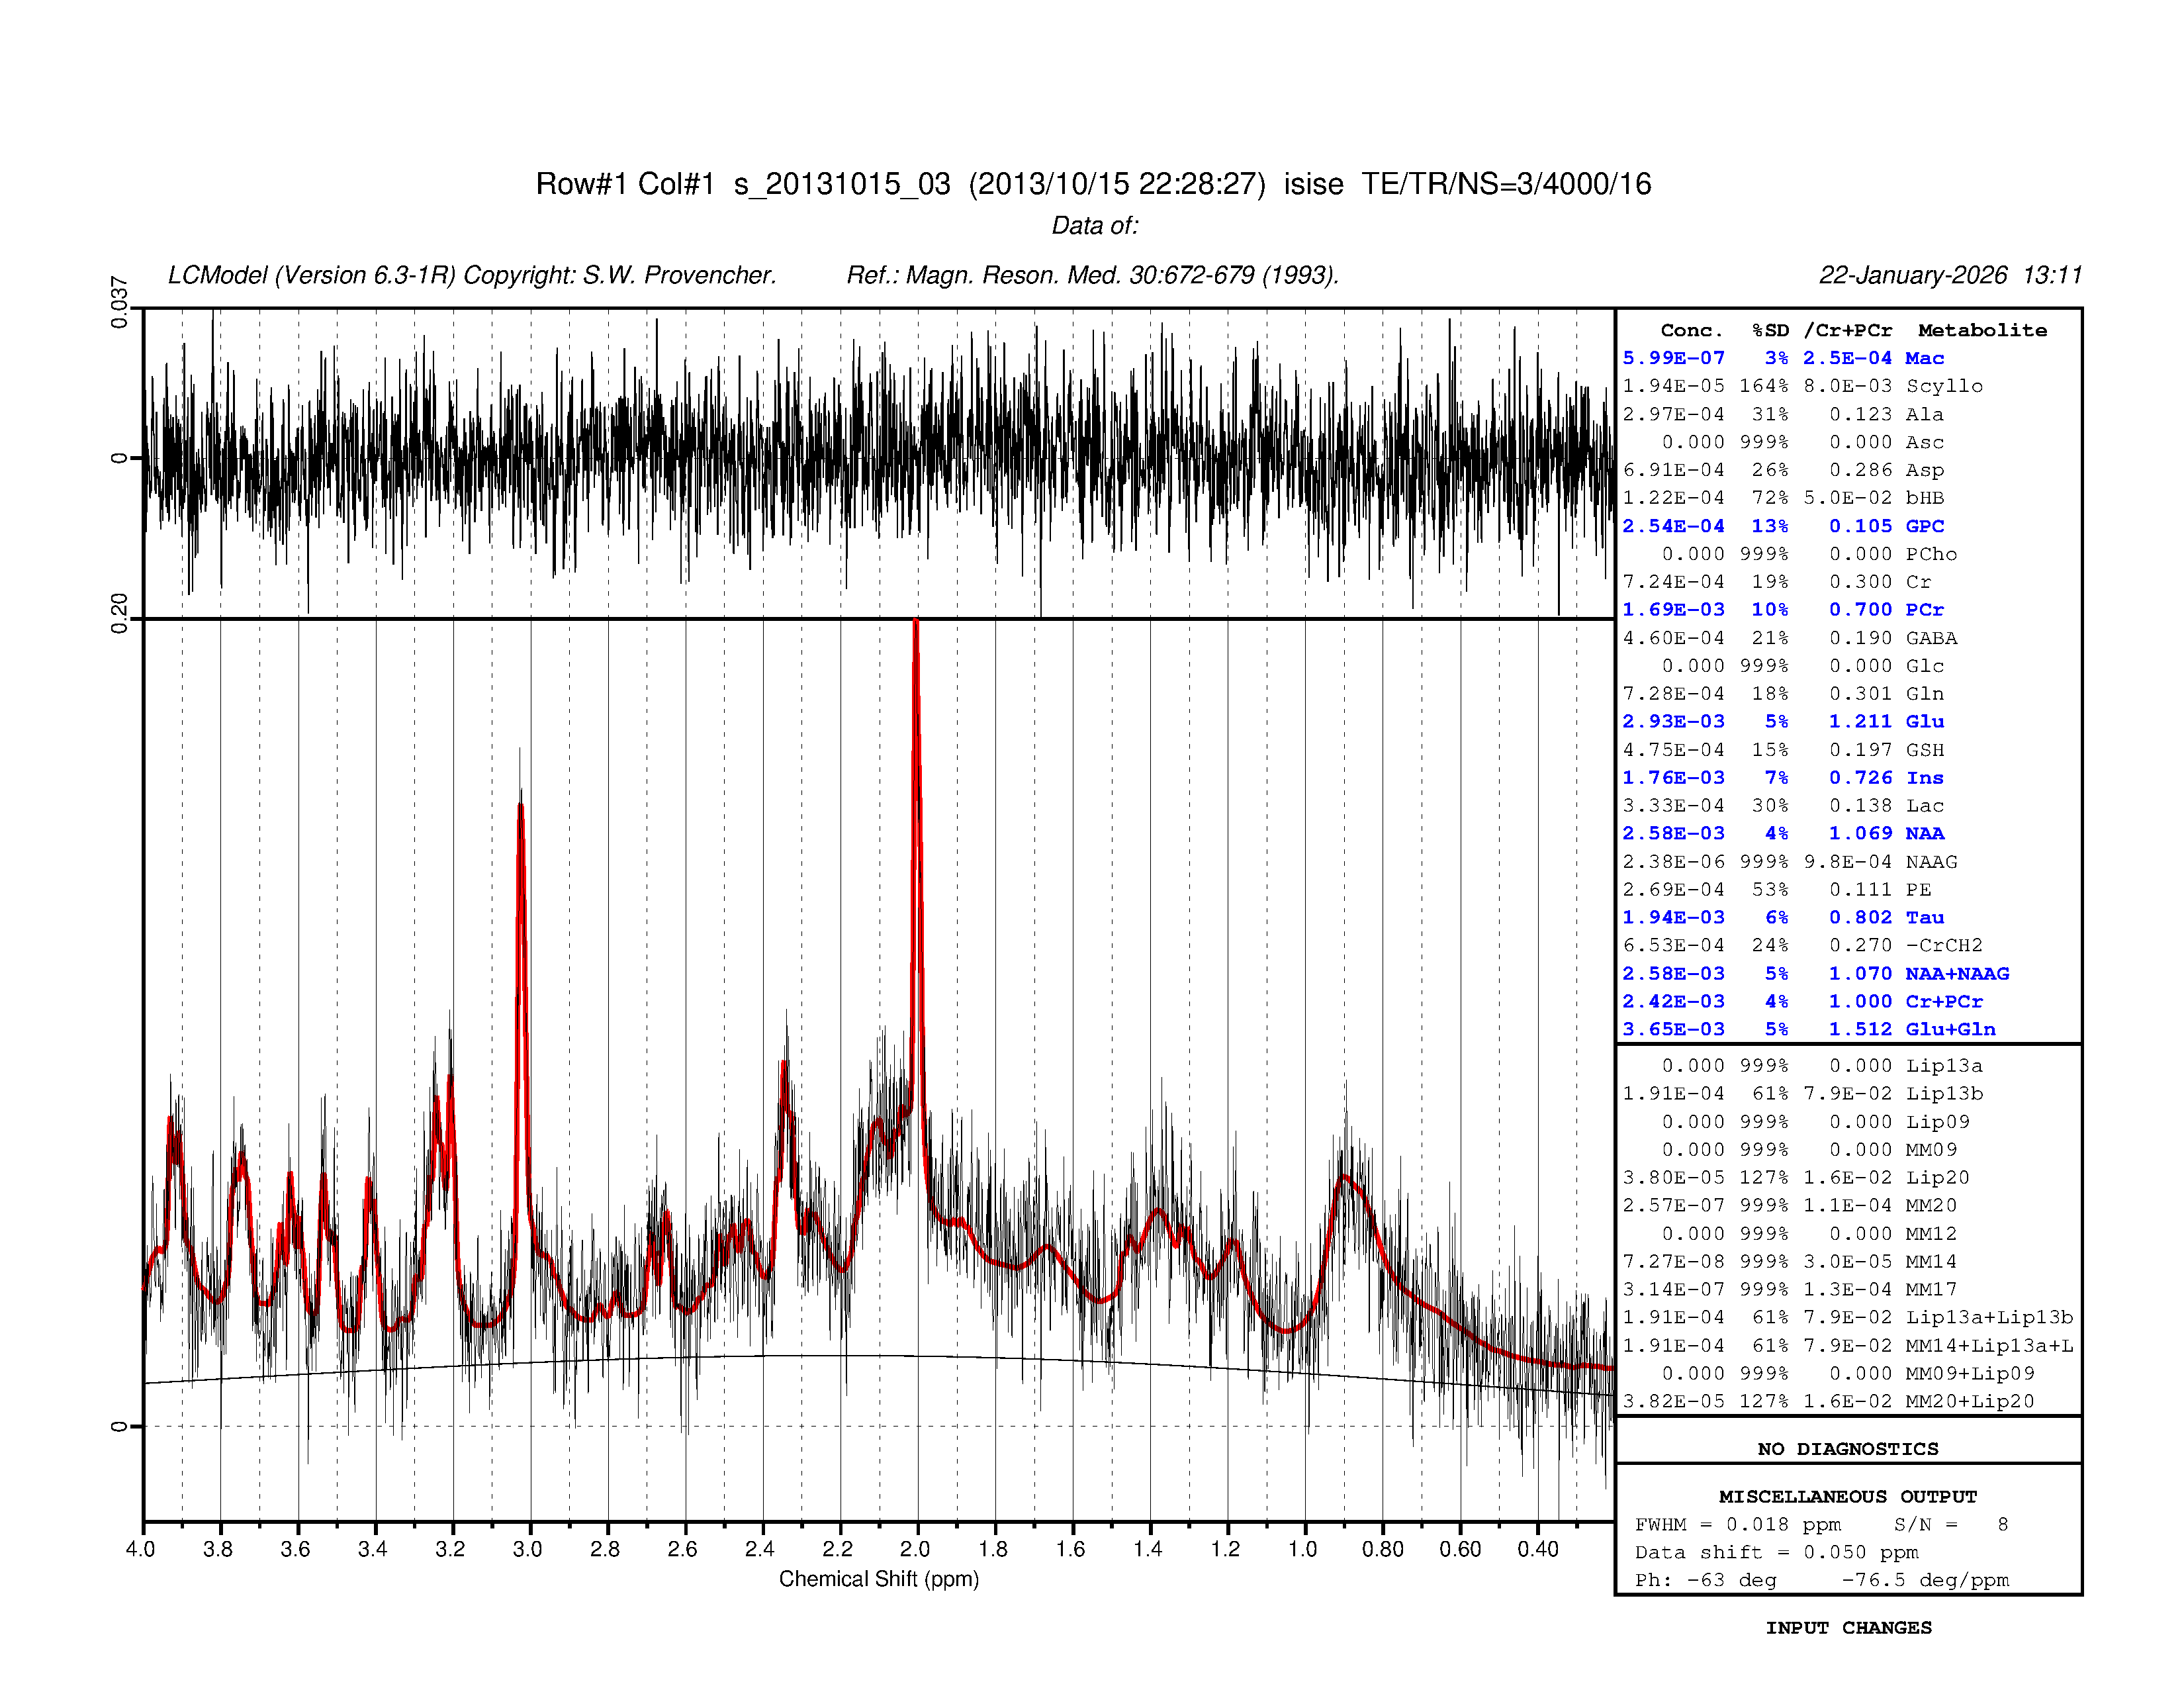

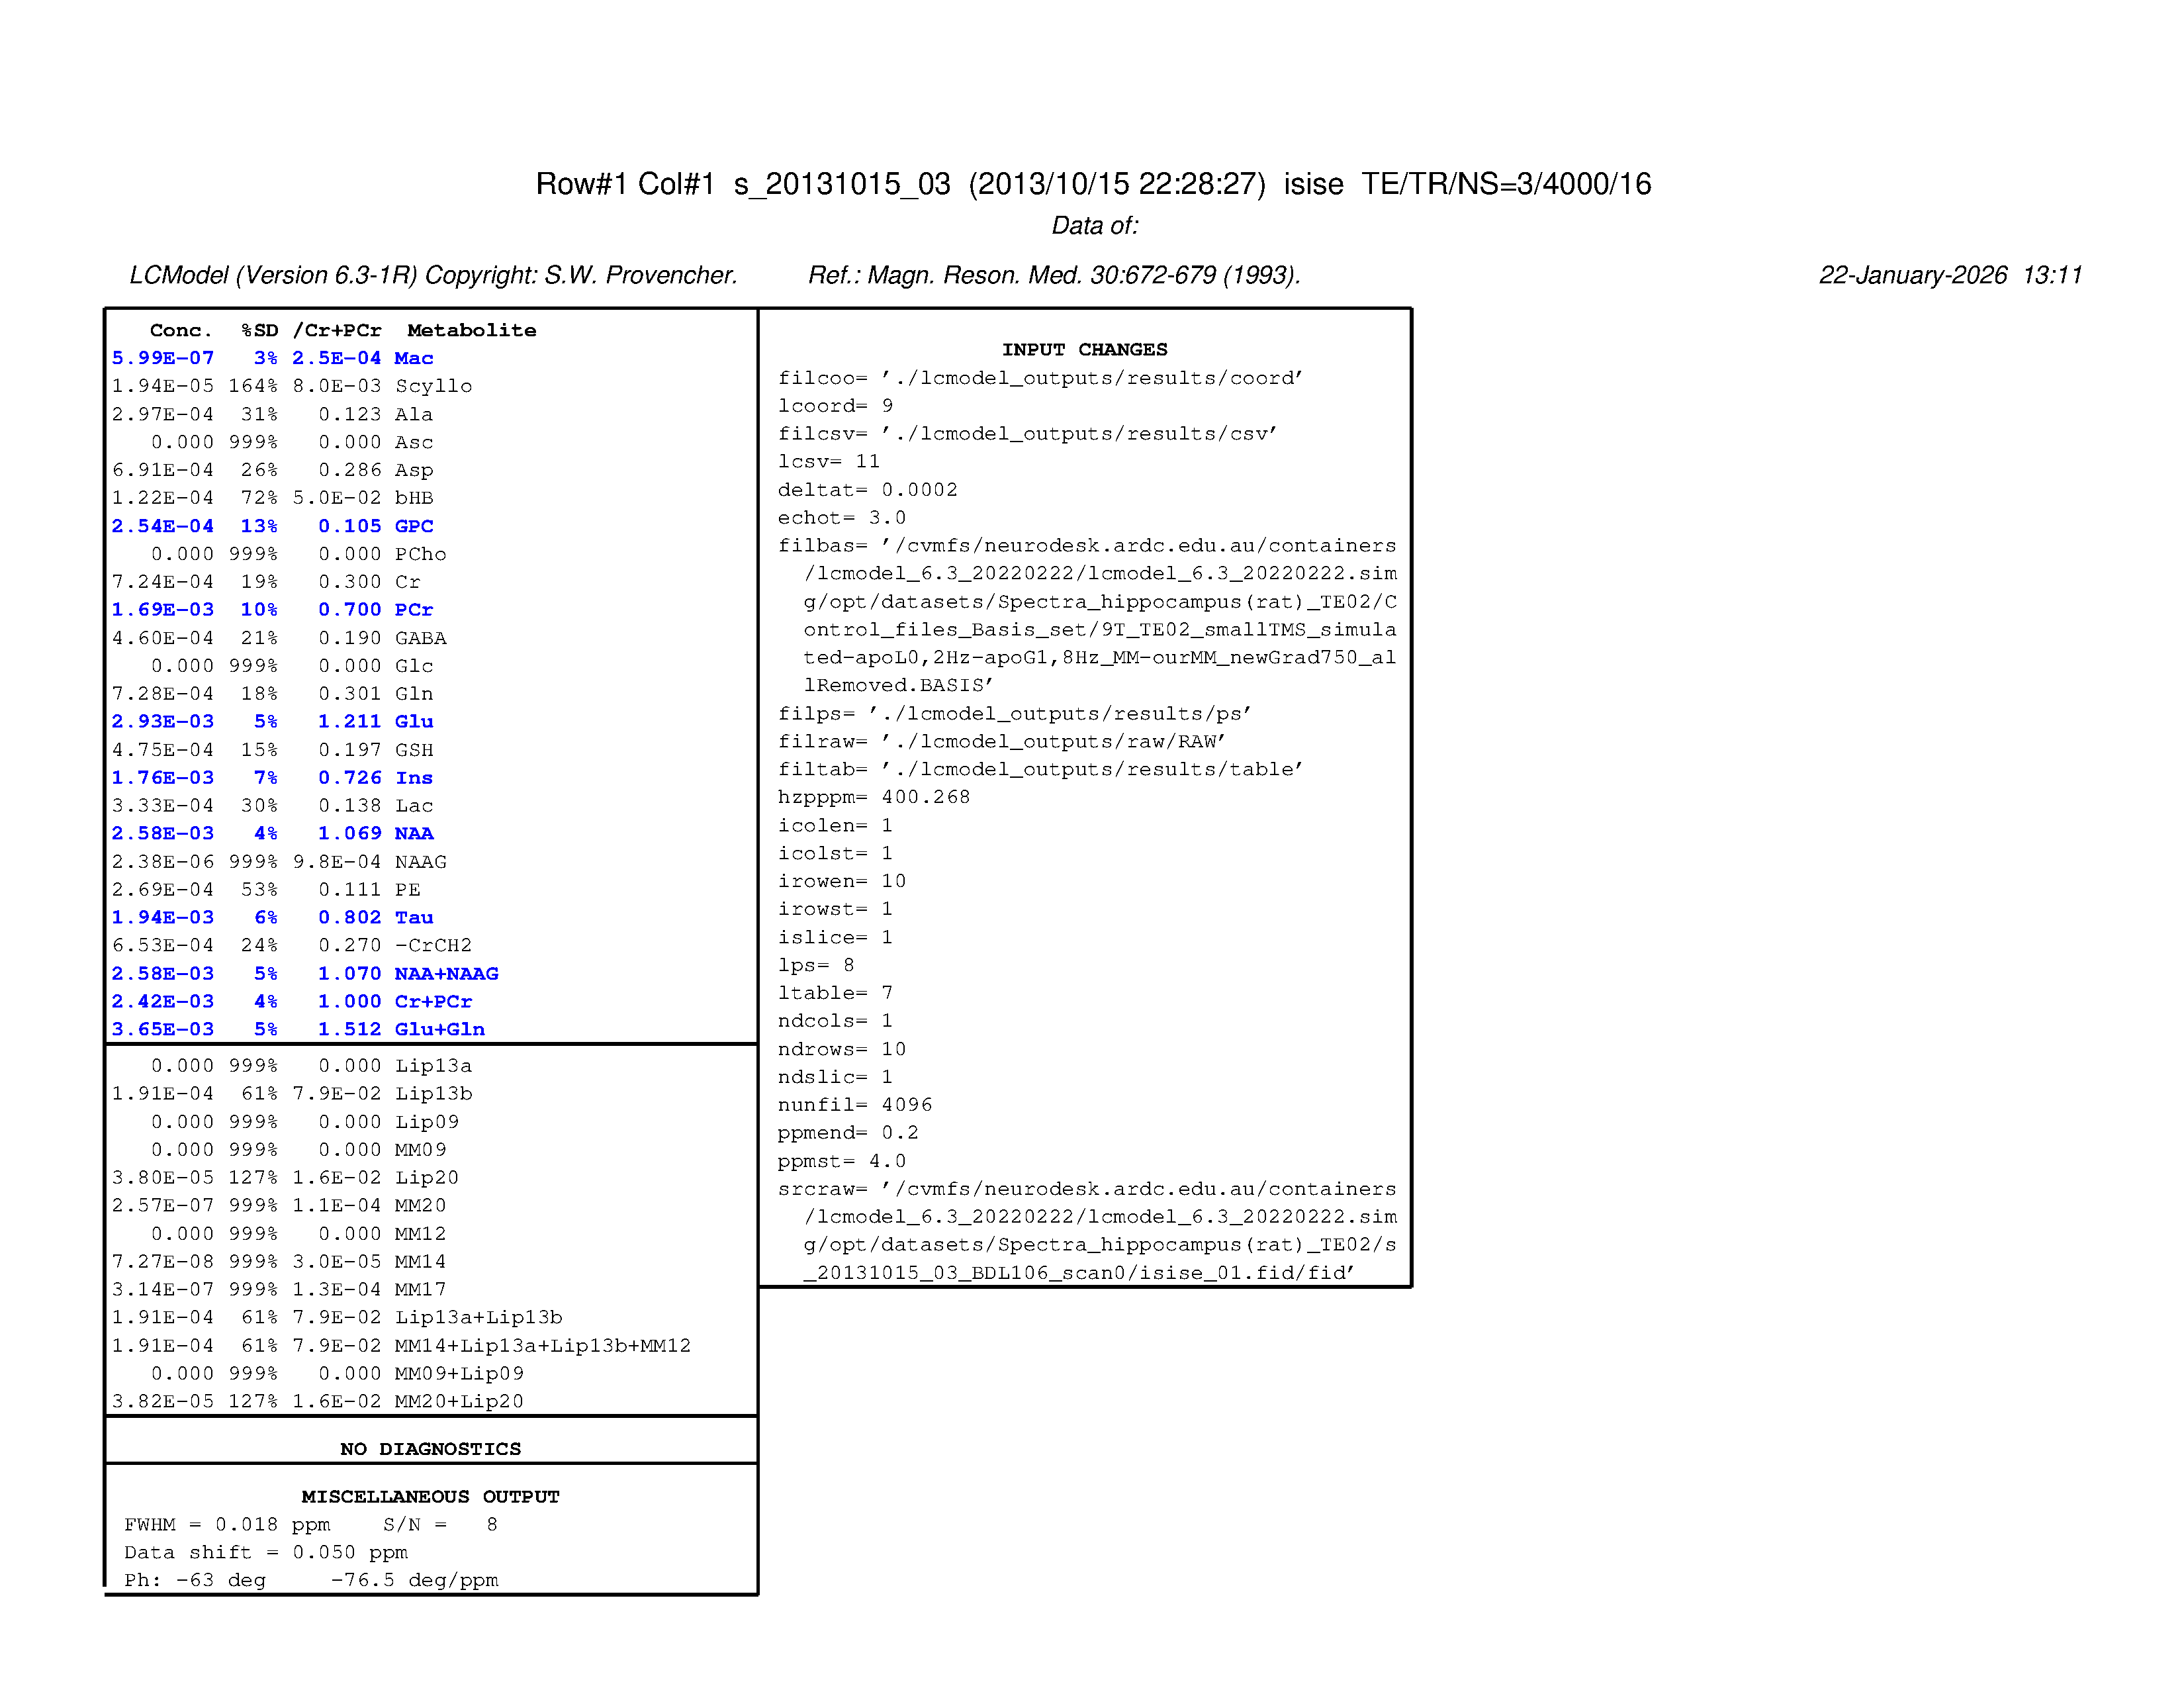

In [19]:
# display the to png images (two pdf pages)
for i in range(1, 2 + 1): 
    display(Image(filename=f"./lcmodel_outputs/results/sl1_1-1_page_{i}.png"))

**Note on PDF viewing:** PDFs can be displayed directly within Jupyter notebooks using `IFrame`, but this only works in interactive environments (local Jupyter, Colab, etc.). When viewing this notebook on GitHub Pages, the PDFs won't render due to security restrictions.
    
```python
# This works in Jupyter but not on GitHub Pages
IFrame("./lcmodel_outputs/results/sl1_1-1.pdf", width=1000, height=800)
```

####

<div style="background-color: #1e3a5f; padding: 10px; border-radius: 5px; border: 2px solid #3b82f6;">
    <div style="background-color: #2563eb; padding: 5px; border-radius: 5px; font-weight: bold;">
        <span style="font-size: 15px; color: #2563eb; background-color: #dbeafe; border-radius: 50%; width: 20px; height: 20px; display: inline-block; text-align: center; line-height: 20px;">
            💡
        </span> <span style="color: white;"> Helpful Hint:</span>
    </div>
    <p style="margin: 10px 0; color: #e0e7ff;">
To download the output PNGs or PDFs, open the file browser in the <strong>JupyterLab interface</strong>, navigate to the output directory (e.g., <code>./lcmodel_outputs/results/</code>), right-click the desired file, and select <em>Download</em>.
    </p>
</div>

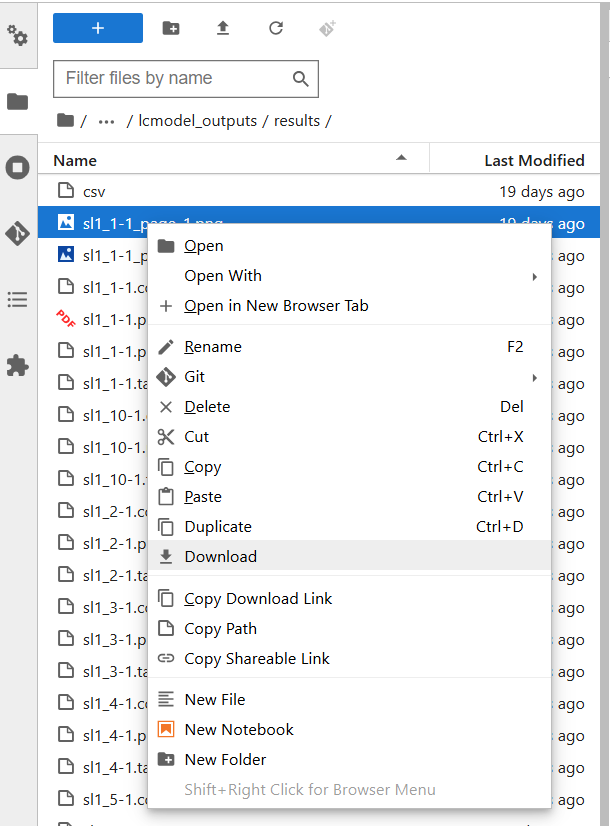

In [19]:
Image(filename='../../static/examples/spectroscopy/lcmodel/download_png.png')

#### Dependencies in Jupyter/Python
- Using the package [watermark](https://github.com/rasbt/watermark) to document system environment and software versions used in this notebook

In [20]:
%load_ext watermark

%watermark
%watermark --iversions

Last updated: 2026-01-22T13:13:25.166308+00:00

Python implementation: CPython
Python version       : 3.13.9
IPython version      : 9.7.0

Compiler    : GCC 14.3.0
OS          : Linux
Release     : 5.15.0-164-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 32
Architecture: 64bit

IPython   : 9.7.0
matplotlib: 3.10.8
nibabel   : 5.3.3
numpy     : 2.3.5
re        : 2.2.1

